In [10]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import sacrebleu
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('mps')

In [11]:
def dataset_iterator(path):
    with open(path) as texts:
        for text in texts:
            yield text.split()

vocab_en = build_vocab_from_iterator(
    dataset_iterator('./data/train.de-en.en'),
    specials=['<pad>', '<unk>', '<bos>', '<eos>'], min_freq=10
)
vocab_en.set_default_index(vocab_en['<unk>'])

vocab_de = build_vocab_from_iterator(
    dataset_iterator('./data/train.de-en.de'),
    specials=['<pad>', '<unk>', '<bos>', '<eos>'], min_freq=10
)
vocab_de.set_default_index(vocab_de['<unk>'])

max_length = 64
def process_data(file_path, vocab, max_len=max_length):
    tokens_list = []
    with open(file_path) as f:
        for line in f:
            tokens = line.strip().split()[:max_len-2]
            indices = [vocab['<bos>']] + [vocab[token] for token in tokens] + [vocab['<eos>']]
            if len(indices) < max_len:
                indices += [vocab['<pad>']] * (max_len - len(indices))
            else:
                indices = indices[:max_len]
            tokens_list.append(indices)
    return torch.tensor(tokens_list, dtype=torch.long)

tokenized_train_de = process_data('./data/train.de-en.de', vocab_de)
tokenized_train_en = process_data('./data/train.de-en.en', vocab_en)
tokenized_val_de = process_data('./data/val.de-en.de', vocab_de)
tokenized_val_en = process_data('./data/val.de-en.en', vocab_en)

train_dataset = TensorDataset(tokenized_train_de, tokenized_train_en)
val_dataset = TensorDataset(tokenized_val_de, tokenized_val_en)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class MultiHeadedAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        q = self.q_linear(q).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        k = self.k_linear(k).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        output = torch.matmul(attn, v)

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.out(output)
        return output

class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1, ff_dim=2048):
        super().__init__()
        self.self_attn = MultiHeadedAttention(heads, d_model, dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1, ff_dim=2048):
        super().__init__()
        self.self_attn = MultiHeadedAttention(heads, d_model, dropout)
        self.enc_attn = MultiHeadedAttention(heads, d_model, dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, trg_mask):
        self_attn_output = self.self_attn(x, x, x, trg_mask)
        x = self.norm1(x + self.dropout1(self_attn_output))
        enc_attn_output = self.enc_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout2(enc_attn_output))
        ff_output = self.ff(x)
        x = self.norm3(x + self.dropout3(ff_output))
        return x

class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout, max_length):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model, max_length)
        self.layers = nn.ModuleList([EncoderLayer(d_model, heads, dropout) for _ in range(N)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout, max_length):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model, max_length)
        self.layers = nn.ModuleList([DecoderLayer(d_model, heads, dropout) for _ in range(N)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_output, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, enc_output, src_mask, trg_mask)
        return x

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, d_model=512, N=6, heads=8, dropout=0.1, max_length=100):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, N, heads, dropout, max_length)
        self.decoder = Decoder(trg_vocab_size, d_model, N, heads, dropout, max_length)
        self.fc_out = nn.Linear(d_model, trg_vocab_size)
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.max_length = max_length

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src, src_mask)
        dec_out = self.decoder(trg, enc_out, src_mask, trg_mask)
        output = self.fc_out(dec_out)
        return output

In [ ]:
src_vocab_size = len(vocab_de)
trg_vocab_size = len(vocab_en)
src_pad_idx = vocab_de['<pad>']
trg_pad_idx = vocab_en['<pad>']

# model = Transformer(
#     src_vocab_size, trg_vocab_size,
#     src_pad_idx, trg_pad_idx,
#     N=3,
#     dropout=0.2,
#     max_length=max_length
# ).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
# criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, dropout=0.3, max_length=max_length).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

In [14]:
def translate_batch(model, src, max_len, trg_bos_idx, trg_eos_idx, device):
    model.eval()
    src_mask = model.make_src_mask(src)
    enc_out = model.encoder(src, src_mask)

    batch_size = src.size(0)
    trg = torch.ones(batch_size, 1, dtype=torch.long).fill_(trg_bos_idx).to(device)
    for i in range(max_len - 1):
        trg_mask = model.make_trg_mask(trg)
        with torch.no_grad():
            output = model.decoder(trg, enc_out, src_mask, trg_mask)
            output = model.fc_out(output)
            pred = output.argmax(2)[:, -1].unsqueeze(1)
        trg = torch.cat([trg, pred], dim=1)

        if (pred == trg_eos_idx).all():
            break
    return trg

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    best_bleu = 0.0
    history = {'train_loss': [], 'val_loss': [], 'bleu': []}
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for i, (src, trg) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')):
            src, trg = src.to(device), trg.to(device)
            
            optimizer.zero_grad()
            output = model(src, trg[:, :-1])
            loss = criterion(output.reshape(-1, trg_vocab_size), trg[:, 1:].reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        all_hypotheses = []
        all_references = []
        
        with torch.no_grad():
            for i, (src, trg) in enumerate(tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]')):
                src, trg = src.to(device), trg.to(device)
                
                output = model(src, trg[:, :-1])
                loss = criterion(output.reshape(-1, trg_vocab_size), trg[:, 1:].reshape(-1))
                total_val_loss += loss.item()
                
                trg_pred = translate_batch(
                    model, src, max_length, 
                    vocab_en['<bos>'], vocab_en['<eos>'], device
                )
                
                for i in range(trg_pred.size(0)):
                    pred_seq = trg_pred[i].cpu().tolist()
                    pred_tokens = []
                    for tok in pred_seq:
                        if tok == vocab_en['<eos>']:
                            break
                        if tok != vocab_en['<bos>']:
                            pred_tokens.append(vocab_en.lookup_token(tok))
                    all_hypotheses.append(' '.join(pred_tokens))
                    
                    ref_seq = trg[i].cpu().tolist()
                    ref_tokens = []
                    for tok in ref_seq:
                        if tok == vocab_en['<eos>']:
                            break
                        if tok != vocab_en['<bos>']:
                            ref_tokens.append(vocab_en.lookup_token(tok))
                    all_references.append(' '.join(ref_tokens))
        
        avg_val_loss = total_val_loss / len(val_loader)
        bleu_score = sacrebleu.corpus_bleu(all_hypotheses, [all_references], tokenize='none').score
        history['val_loss'].append(avg_val_loss)
        history['bleu'].append(bleu_score)
        
        print(f'\nEpoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print(f'BLEU Score: {bleu_score:.2f}')
        
        if bleu_score > best_bleu:
            best_bleu = bleu_score
            torch.save(model.state_dict(), 'best_model.pt')
    
    print(f'\nTraining Complete! Best BLEU: {best_bleu:.2f}')
    return history

In [16]:
history = train_model(
    model, train_loader, val_loader,
    optimizer, criterion, epochs=20
)

Epoch 1/20 [Val]: 100%|██████████| 16/16 [03:14<00:00, 12.14s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 1/20:
Train Loss: 4.1271 | Val Loss: 3.4133
BLEU Score: 12.88


Epoch 2/20 [Val]: 100%|██████████| 16/16 [03:42<00:00, 13.90s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 2/20:
Train Loss: 3.4389 | Val Loss: 2.9369
BLEU Score: 18.02


Epoch 3/20 [Val]: 100%|██████████| 16/16 [03:49<00:00, 14.35s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 3/20:
Train Loss: 3.0526 | Val Loss: 2.6381
BLEU Score: 21.80


Epoch 4/20 [Val]: 100%|██████████| 16/16 [03:14<00:00, 12.13s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 4/20:
Train Loss: 2.7875 | Val Loss: 2.4610
BLEU Score: 24.37


Epoch 5/20 [Val]: 100%|██████████| 16/16 [03:14<00:00, 12.13s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 5/20:
Train Loss: 2.6007 | Val Loss: 2.3332
BLEU Score: 26.51


Epoch 6/20 [Val]: 100%|██████████| 16/16 [02:22<00:00,  8.88s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 6/20:
Train Loss: 2.4635 | Val Loss: 2.2682
BLEU Score: 28.06


Epoch 7/20 [Val]: 100%|██████████| 16/16 [02:36<00:00,  9.76s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 7/20:
Train Loss: 2.3579 | Val Loss: 2.2027
BLEU Score: 28.73


Epoch 8/20 [Val]: 100%|██████████| 16/16 [03:14<00:00, 12.13s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 8/20:
Train Loss: 2.2730 | Val Loss: 2.1704
BLEU Score: 29.61


Epoch 9/20 [Val]: 100%|██████████| 16/16 [02:45<00:00, 10.32s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 9/20:
Train Loss: 2.2030 | Val Loss: 2.1386
BLEU Score: 30.02


Epoch 10/20 [Val]: 100%|██████████| 16/16 [02:55<00:00, 10.97s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 10/20:
Train Loss: 2.1429 | Val Loss: 2.1115
BLEU Score: 29.95


Epoch 11/20 [Val]: 100%|██████████| 16/16 [03:04<00:00, 11.50s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 11/20:
Train Loss: 2.0909 | Val Loss: 2.0968
BLEU Score: 30.84


Epoch 12/20 [Val]: 100%|██████████| 16/16 [03:17<00:00, 12.35s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 12/20:
Train Loss: 2.0444 | Val Loss: 2.0710
BLEU Score: 31.07


Epoch 13/20 [Val]: 100%|██████████| 16/16 [03:39<00:00, 13.69s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 13/20:
Train Loss: 2.0025 | Val Loss: 2.0678
BLEU Score: 31.30


Epoch 14/20 [Val]: 100%|██████████| 16/16 [02:48<00:00, 10.53s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 14/20:
Train Loss: 1.9647 | Val Loss: 2.0419
BLEU Score: 31.51


Epoch 15/20 [Val]: 100%|██████████| 16/16 [04:08<00:00, 15.51s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 15/20:
Train Loss: 1.9291 | Val Loss: 2.0461
BLEU Score: 32.10


Epoch 16/20 [Val]: 100%|██████████| 16/16 [02:24<00:00,  9.02s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 16/20:
Train Loss: 1.8970 | Val Loss: 2.0314
BLEU Score: 32.00


Epoch 17/20 [Val]: 100%|██████████| 16/16 [02:11<00:00,  8.23s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 17/20:
Train Loss: 1.8667 | Val Loss: 2.0337
BLEU Score: 32.21


Epoch 18/20 [Val]: 100%|██████████| 16/16 [02:38<00:00,  9.88s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 18/20:
Train Loss: 1.8392 | Val Loss: 2.0248
BLEU Score: 32.11


Epoch 19/20 [Val]: 100%|██████████| 16/16 [02:10<00:00,  8.14s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 19/20:
Train Loss: 1.8126 | Val Loss: 2.0241
BLEU Score: 32.51


Epoch 20/20 [Val]: 100%|██████████| 16/16 [02:09<00:00,  8.07s/it]
That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



Epoch 20/20:
Train Loss: 1.7877 | Val Loss: 2.0239
BLEU Score: 32.15

Training Complete! Best BLEU: 32.51


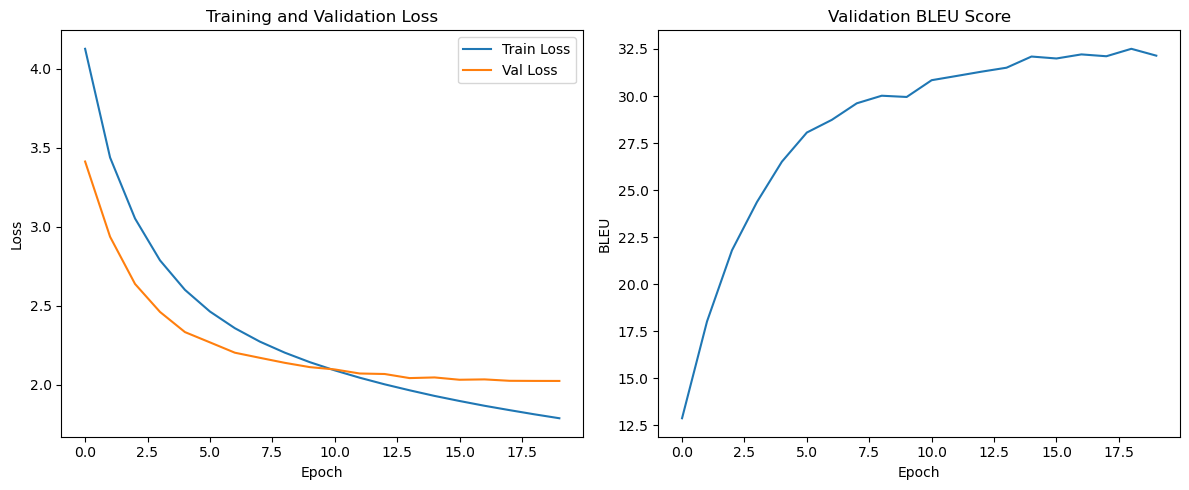

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['bleu'])
plt.title('Validation BLEU Score')
plt.xlabel('Epoch')
plt.ylabel('BLEU')
plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

In [18]:
test_de = process_data('./data/test1.de-en.de', vocab_de)
test_loader = DataLoader(test_de, batch_size=batch_size, shuffle=False)

def generate_translations(model, test_loader, output_file):
    model.eval()
    trg_bos_idx = vocab_en['<bos>']
    trg_eos_idx = vocab_en['<eos>']
    with open(output_file, 'w') as f:
        for src in tqdm(test_loader):
            src = src.to(device)
            trg = translate_batch(model, src, max_length, trg_bos_idx, trg_eos_idx, device)
            trg = trg.cpu().numpy()
            for seq in trg:
                tokens = []
                for tok in seq:
                    tok = tok.item()
                    if tok == trg_bos_idx:
                        continue
                    if tok == trg_eos_idx:
                        break
                    tokens.append(vocab_en.lookup_token(tok))
                line = ' '.join(tokens)
                f.write(line + '\n')

generate_translations(model, test_loader, 'test1.de-en.en')

100%|██████████| 47/47 [03:32<00:00,  4.53s/it]


<img src="https://media1.tenor.com/m/HleFU8PrawUAAAAC/sigh-ladybug.gif">

<img src="https://media1.tenor.com/m/3onS--0uT0cAAAAC/pain-suffering.gif">